# __Rice Classification Using CNN With Pytorch and LIME__

I developed a deep learning model to classify five distinct rice types based on image data from [Kaggle](https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset). Using a Convolutional Neural Network (CNN) using PyTorch, the model is trained on a dataset of 75,000 grayscale images of rice grains, consisting of 15,000 images each for Arborio, Basmati, Ipsala, Jasmine, and Karacadag. The goal of the model is to accurately classify the rice varieties based on their image characteristics. To enhance interpretability, I employed Local Interpretable Model-agnostic Explanations (LIME), a method that provides visual insights into the decision-making process of the model. LIME generates localized explanations by highlighting the most relevant image segments that contributed to each classification decision. Through LIME-based explanations, we analyze the visual patterns in rice grains that differentiate various types, identifying key features that the CNN considers during classification. I also performed detailed accuracy evaluations on individual rice types, enabling a deeper understanding of the model's strengths and areas for improvement. This approach provides both high classification accuracy and a transparent interpretability framework for understanding the model's predictions.

Let's begin by importing the libraries:

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 72
from IPython.display import display
import numpy as np
import pandas as pd
import random
from sklearn.metrics import accuracy_score
from collections import defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import sys

print(f'PyTorch version= {torch.__version__}')

PyTorch version= 2.2.1+cu118


Set the GPU to device 0:

In [7]:
Device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
torch.cuda.empty_cache()

In [9]:
# Define transformations for 1-channel grayscale images
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) ])

# Load the dataset
dataset_path = 'C:\\Users\\lkim8\\OneDrive\\Documents\\Portfolio\\Rice_Image_Dataset'
rice_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Get dataset length and split train/validate/test sizes
dataset_size = len(rice_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(rice_dataset, [train_size, val_size, test_size])

# Define batch size
batch_size = 64  # Adjust this based on memory capacity and experiment

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check the shapes of a batch
for images, labels in train_loader:
    print(f'train_loader shape: {images.shape}')
    break

for images, labels in val_loader:
    print(f'val_loader shape: {images.shape}')
    break

for images, labels in test_loader:
    print(f'test_loader shape: {images.shape}')
    break

train_loader shape: torch.Size([64, 1, 128, 128])
val_loader shape: torch.Size([64, 1, 128, 128])
test_loader shape: torch.Size([64, 1, 128, 128])


Plot the first 25 images from the datasets:

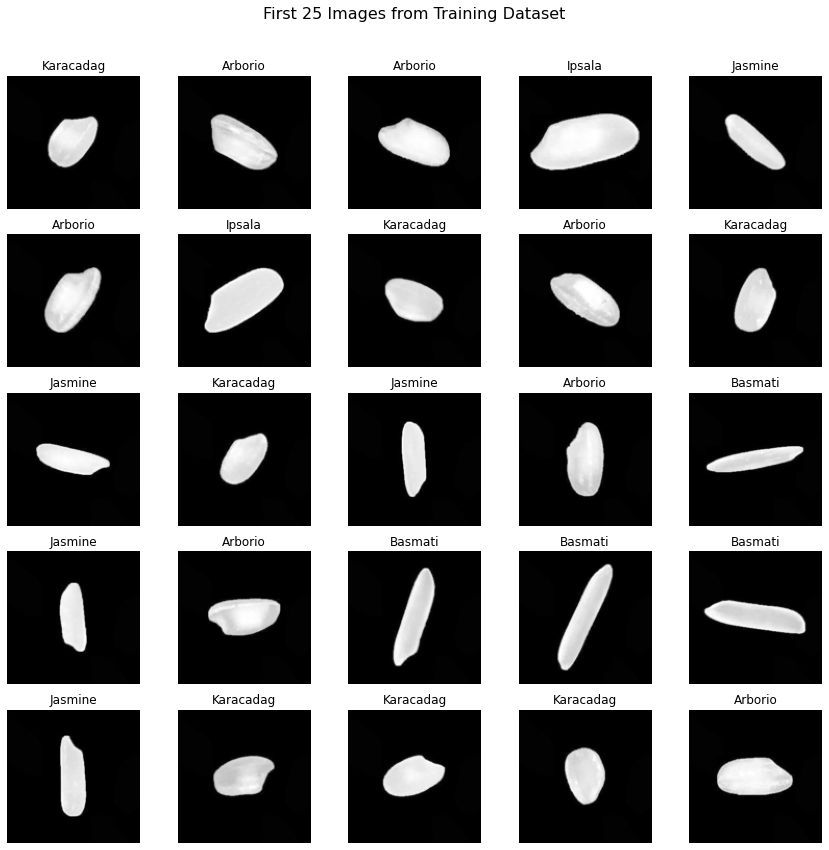

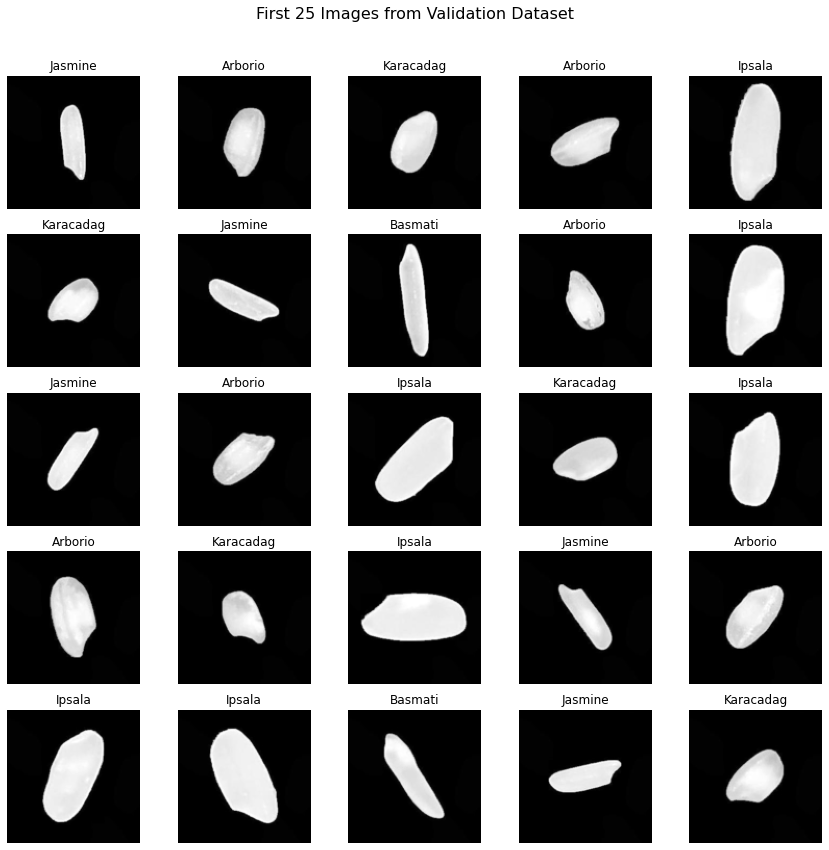

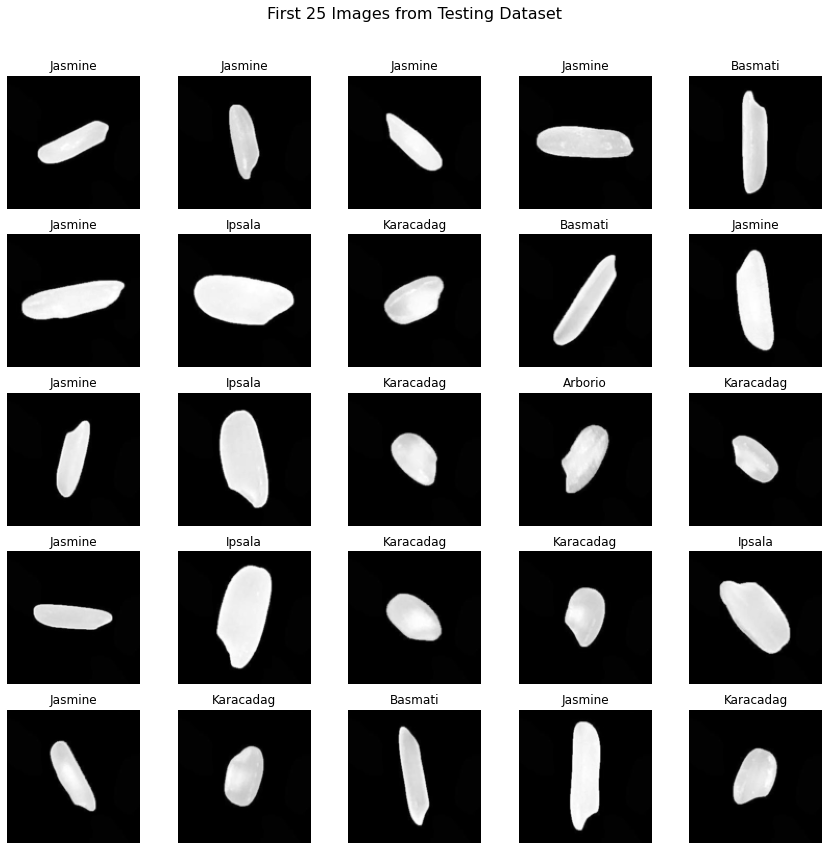

In [11]:
# Define a mapping for class labels to rice names
labels_map = {
    0: "Arborio",
    1: "Basmati",
    2: "Ipsala",
    3: "Jasmine",
    4: "Karacadag" }

def plot_images(loader, labels_map, title):
    images, labels = next(iter(loader))  # Get the first batch of images and labels
    images, labels = images[:25], labels[:25]  # Take only the first 25

    fig, axes = plt.subplots(5, 5, figsize=(12, 12))
    fig.suptitle(f'First 25 Images from {title}', fontsize=16)

    for ax, img, label in zip(axes.flatten(), images, labels):
        ax.imshow(img[0], cmap='gray') 
        ax.set_title(labels_map[label.item()])
        ax.axis('off') 

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

plot_images(train_loader, labels_map, title='Training Dataset')
plot_images(val_loader, labels_map, title='Validation Dataset')
plot_images(test_loader, labels_map, title='Testing Dataset')

All rice images are centered, but are at different rotations from each other.

## __Complete CNN with PyTorch__

Create the `PytorchCNN` class to be used for LIME XAI so we can have a better understanding of which parts of the features drive which classes. Since I am working with a relatively large dataset with 75,000 images, the CNN will have 3 layers to better capture the subtle differences between the rice grain type:

In [14]:
IMG_CHANNEL= 1
MLP_HIDDEN= 64

LAST_LINEAR_SIZE = 1024

class PyTorchCNN(nn.Module):
    def __init__(self, epochs=10, eta=0.001, minibatch_size=64, seed=0, input_channels=1, output_size=5, loss_func=nn.CrossEntropyLoss(), supplied_model=None, prediction_problem='classification'):
        super().__init__()
        self.epochs = epochs
        self.eta = eta
        self.minibatch_size = minibatch_size
        self.random = np.random.RandomState(seed)
        self.input_channels = input_channels
        self.output_size = output_size
        self.loss_func = loss_func
        self.prediction_problem = prediction_problem
        self.supplied_model = supplied_model
        if self.supplied_model:
            self.model = self.supplied_model
        else:
            self.init_layers(input_channels, output_size)

    def init_layers(self, _M:int, _K:int) -> None:
        _M = IMG_CHANNEL
        
        self.model = nn.Sequential(
            nn.Conv2d(_M, MLP_HIDDEN, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(MLP_HIDDEN),
            
            nn.Conv2d(MLP_HIDDEN, MLP_HIDDEN * 2, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), 
            nn.BatchNorm2d(MLP_HIDDEN * 2), 

            nn.Conv2d(MLP_HIDDEN * 2, MLP_HIDDEN * 4, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(MLP_HIDDEN * 4),

            nn.Flatten(start_dim=1),

            nn.Linear(MLP_HIDDEN * 4 * 12 * 12, LAST_LINEAR_SIZE),

            nn.BatchNorm1d(LAST_LINEAR_SIZE),

            nn.Linear(LAST_LINEAR_SIZE, _K)
        )
    
    def fit(self, train_loader, val_loader=None, info=False, device='cpu'):
        self.model = self.model.to(device)
        self.optimizer = torch.optim.Rprop(self.model.parameters(), lr=self.eta)

        train_losses = []
        train_accuracies = []
        val_losses = []
        val_accuracies = []
        
        for epoch in range(self.epochs):
            self.model.train()  # Set model to training mode
            running_loss = 0.0
            correct_train = 0
            total_train = 0

            for i, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                self.optimizer.zero_grad()

                # Forward pass
                outputs = self.model(inputs)
                loss = self.loss_func(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()

                # Calculate training accuracy for this batch
                _, predicted = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

                # view real-time progress updates
                if info:
                    sys.stderr.write(f"\rEpoch {epoch+1}/{self.epochs}, Batch {i+1}/{len(train_loader)} Loss: {loss.item():6.5f}")
                    sys.stderr.flush()

            # Store the average training loss and accuracy for this epoch
            avg_train_loss = running_loss / len(train_loader)
            train_losses.append(avg_train_loss)
            
            train_accuracy = 100 * correct_train / total_train
            train_accuracies.append(train_accuracy)
            
            if info:
                print(f"\nEpoch {epoch+1}, Training Loss: {running_loss / len(train_loader):6.5f}, Accuracy: {train_accuracy:.2f}")

            if val_loader:
                val_loss, val_accuracy = self.validate(val_loader, device)
                val_losses.append(val_loss)
                val_accuracies.append(val_accuracy)

        plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies)

    def validate(self, val_loader, device='cpu'):
        self.model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = self.model(inputs)
                loss = self.loss_func(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        avg_val_loss = val_loss / len(val_loader)
        
        print(f"Validation Loss: {val_loss / len(val_loader):6.5f}, Accuracy: {val_accuracy:.2f}%\n")

        return avg_val_loss, val_accuracy

    def predict(self, loader, device='cpu'):
        self.model.to(device)
        self.model.eval()  # Set model to evaluation mode
    
        all_preds = []
        with torch.no_grad():  # Disable gradient computation for faster prediction
            for images, _ in loader:
                images = images.to(device)
                logits = self.model(images)
                preds = torch.argmax(logits, dim=1)
                all_preds.append(preds.cpu().numpy())
    
        self.model.train()  # Return to training mode
        return np.concatenate(all_preds)  # Return as single array
    
    def predict_proba(self, images, device='cpu'):
        self.model.eval()  # Set model to evaluation mode
        images = images.to(Device)
        
        with torch.no_grad():  # Disable gradient calculation for faster inference
            logits = self.model(images)  # Forward pass through the model
            probs = torch.softmax(logits, dim=1)  # Convert logits to probabilities
        
        return probs.cpu().numpy()  # Return the probabilities as a NumPy array

This CNN is designed to be trained with a gray scale images.

## __Evaluate the CNN__

In this section, I will train, validate, and test the CNN with 15 epochs and plot the training and validation accuracies and losses. I chose to do 15 epochs since the difference in training and validation losses between 15 and 20 epochs were very small and to save time on training and validating the model.

In [17]:
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies):
        epochs = range(1, len(train_accuracies) + 1)
        
        plt.figure(figsize=(12, 6))
    
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
        plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='red')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_losses, label='Train Loss', color='blue')
        plt.plot(epochs, val_losses, label='Validation Loss', color='red')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
    
        # plt.tight_layout()
        plt.show()

Epoch 1/15, Batch 821/821 Loss: 0.02113


Epoch 1, Training Loss: 0.17775, Accuracy: 94.74


Epoch 2/15, Batch 1/821 Loss: 0.11143

Validation Loss: 0.13026, Accuracy: 95.81%



Epoch 2/15, Batch 821/821 Loss: 0.03197


Epoch 2, Training Loss: 0.12191, Accuracy: 96.20


Epoch 3/15, Batch 1/821 Loss: 0.04255

Validation Loss: 0.10448, Accuracy: 96.68%



Epoch 3/15, Batch 821/821 Loss: 0.10336


Epoch 3, Training Loss: 0.10688, Accuracy: 96.56


Epoch 4/15, Batch 1/821 Loss: 0.06170

Validation Loss: 0.09780, Accuracy: 96.83%



Epoch 4/15, Batch 821/821 Loss: 0.12487


Epoch 4, Training Loss: 0.09852, Accuracy: 96.82


Epoch 5/15, Batch 1/821 Loss: 0.17552

Validation Loss: 0.08920, Accuracy: 97.20%



Epoch 5/15, Batch 821/821 Loss: 0.16239


Epoch 5, Training Loss: 0.08928, Accuracy: 97.09


Epoch 6/15, Batch 1/821 Loss: 0.19519

Validation Loss: 0.08428, Accuracy: 97.28%



Epoch 6/15, Batch 821/821 Loss: 0.01669


Epoch 6, Training Loss: 0.08419, Accuracy: 97.23


Epoch 7/15, Batch 1/821 Loss: 0.07224

Validation Loss: 0.07955, Accuracy: 97.60%



Epoch 7/15, Batch 821/821 Loss: 0.06357


Epoch 7, Training Loss: 0.07719, Accuracy: 97.42


Epoch 8/15, Batch 1/821 Loss: 0.04303

Validation Loss: 0.07564, Accuracy: 97.55%



Epoch 8/15, Batch 821/821 Loss: 0.01355


Epoch 8, Training Loss: 0.07425, Accuracy: 97.56


Epoch 9/15, Batch 1/821 Loss: 0.03506

Validation Loss: 0.07018, Accuracy: 97.72%



Epoch 9/15, Batch 821/821 Loss: 0.00370


Epoch 9, Training Loss: 0.06739, Accuracy: 97.85


Epoch 10/15, Batch 1/821 Loss: 0.01067

Validation Loss: 0.06805, Accuracy: 97.84%



Epoch 10/15, Batch 821/821 Loss: 0.00752


Epoch 10, Training Loss: 0.06504, Accuracy: 97.87


Epoch 11/15, Batch 1/821 Loss: 0.01782

Validation Loss: 0.06246, Accuracy: 97.92%



Epoch 11/15, Batch 821/821 Loss: 0.33995


Epoch 11, Training Loss: 0.05965, Accuracy: 98.03


Epoch 12/15, Batch 1/821 Loss: 0.14777

Validation Loss: 0.06033, Accuracy: 97.96%



Epoch 12/15, Batch 821/821 Loss: 0.01372


Epoch 12, Training Loss: 0.05572, Accuracy: 98.16


Epoch 13/15, Batch 1/821 Loss: 0.04795

Validation Loss: 0.05833, Accuracy: 97.97%



Epoch 13/15, Batch 821/821 Loss: 0.00240


Epoch 13, Training Loss: 0.05370, Accuracy: 98.23


Epoch 14/15, Batch 1/821 Loss: 0.09146

Validation Loss: 0.05325, Accuracy: 98.21%



Epoch 14/15, Batch 821/821 Loss: 0.00842


Epoch 14, Training Loss: 0.05062, Accuracy: 98.34


Epoch 15/15, Batch 1/821 Loss: 0.01257

Validation Loss: 0.05105, Accuracy: 98.35%



Epoch 15/15, Batch 821/821 Loss: 0.00740


Epoch 15, Training Loss: 0.04645, Accuracy: 98.47
Validation Loss: 0.04925, Accuracy: 98.44%



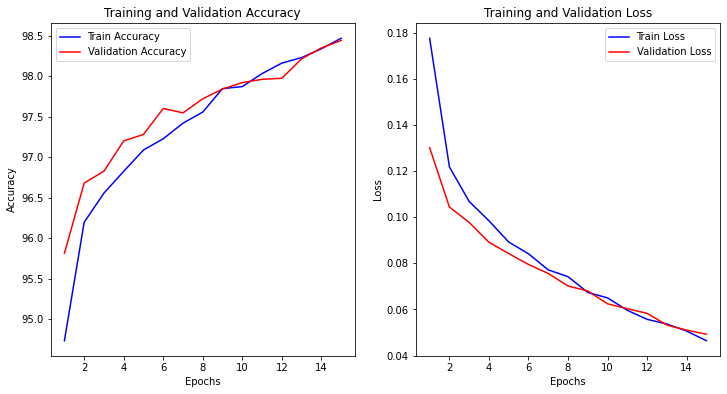

CPU times: total: 26min 51s
Wall time: 26min 20s


In [18]:
%%time

cnn = PyTorchCNN(epochs=15, minibatch_size=64)

cnn.fit(train_loader, val_loader=val_loader, info=True, device=Device)

The training loss decreases consistently, starting from 0.17775 in epoch 1 to 0.04645 in epoch 15, indicating that the model is learning and improving over time. Training accuracy improves from 94.74% in epoch 1 to 98.47% by epoch 15. This demonstrates that the model is increasingly able to classify the training data correctly, thus reflecting strong performance. The validation loss also shows a significant decrease from 0.13026 in epoch 1 to 0.04925 in epoch 15. This suggests that the model generalizes well to the unseen validation data. Validation accuracy improves consistently from 95.81% in epoch 1 to 98.44% in epoch 15. This is very close to the training accuracy, indicating minimal overfitting and strong generalization. Both training and validation losses continue to decline steadily without significant jumps, suggesting that the model’s learning rate is appropriate, and there are no signs of instability or overfitting.

In [20]:
%%time

y_pred = cnn.predict(test_loader, device=Device)

y_ts = np.concatenate([labels.numpy() for _, labels in test_loader])

accuracy_y_pred = accuracy_score(y_ts, y_pred)
print(f'Average prediction accuracy: {accuracy_y_pred}')

unique_labels = np.unique(y_ts)

label_accuracies = {}
for label in unique_labels:
    # Get indices for the current label
    label_indices = (y_ts == label)
    
    # Get true and predicted values for the current label
    y_true_label = y_ts[label_indices]
    y_pred_label = y_pred[label_indices]
    
    # Calculate accuracy for the current label
    accuracy_label = accuracy_score(y_true_label, y_pred_label)
    
    # Store the accuracy in the dictionary
    label_accuracies[label] = accuracy_label
    print(f'Accuracy for {labels_map[label]}: {accuracy_label}')

Average prediction accuracy: 0.9851333333333333
Accuracy for Arborio: 0.9772951628825272
Accuracy for Basmati: 0.9834254143646409
Accuracy for Ipsala: 0.9973027646662171
Accuracy for Jasmine: 0.9876336898395722
Accuracy for Karacadag: 0.9801777170198223
CPU times: total: 35.7 s
Wall time: 35.8 s


The average prediction accuracy across all 5 rice classes is 98.5%, which is really good. When you look at the individual accuracies, Ipsala got the highest accuracy of 99.7% while other rice classes were in the range of 97-98%.

## __LIME Explainable AI__

The `LimeImageExplainer()` will be used to explain the images and their predictions to find out the relations between certain pixels of the images and the predictions. The method `predict_lime` accepts a rice image and returns the prediction probabilities of the gray images using the developed CNN:

In [22]:
from lime import lime_image
from skimage.color import rgb2gray

explainer = lime_image.LimeImageExplainer()

def predict_lime(_color_img):
    # Convert the input RGB image to grayscale since the CNN was trained on grayscale images
    gray_img = rgb2gray(_color_img).reshape(-1, 1, 128, 128)
    gray_img_tensor = torch.tensor(gray_img, dtype=torch.float32)
    gray_img_tensor = gray_img_tensor.to(Device)
    return cnn.predict_proba(gray_img_tensor)

## __Explainable AI (XAI)__

Lets visualize the images and their explanation by `explainer.explain_instance`, using the `classifier_fn=predict_lime` as a parameter. Custom slic segmentation function is created to control the number of superpixels, shape of the superpixels (tightness of the mask to lime image, lower value is tighter), and Gaussian smoothing application before segmentation:

In [24]:
from skimage.segmentation import mark_boundaries
from skimage.segmentation import slic

# Function to plot original image, lime image, mask, and lime image with mask together
def plot(_img, _img_lime, _mask, rice_class):
    fig, ax = plt.subplots(nrows=1, ncols=4, sharex='all', sharey='all', figsize=(13, 5), dpi=72)
    
    ax[0].imshow(_img, cmap='gray')
    ax[0].set_title(f'{rice_class} - Original Image')
    
    ax[1].imshow((_img_lime * 255).astype(np.uint8))
    ax[1].set_title('LIME Image')
    
    ax[2].imshow(_mask)
    ax[2].set_title('Mask')
    
    ax[3].imshow((mark_boundaries(_img_lime, _mask, color=(0, 1, 0)) * 255).astype(np.uint8))
    ax[3].set_title('Image with Mask')
    
    plt.tight_layout()
    plt.show()

# Custom slic segmentation function
def custom_segmentation(image):
    return slic(image, n_segments=20, compactness=220, sigma=1)

# Plots multiple images per class
def exp_ix(test_loader, class_labels, num_images=10):
    for label in class_labels:
        count = 0
        for images, labels in test_loader:
            for i in range(images.size(0)):
                if labels[i].item() == label and count < num_images:
                    img = images[i].cpu().numpy()  # Get the image from the batch
                    img = img.squeeze()  # Remove the channel dimension (now shape (128, 128))

                    # Call the explainer directly with the grayscale image
                    exp = explainer.explain_instance(image=img, classifier_fn=predict_lime, segmentation_fn=custom_segmentation)
                    
                    # Get the processed image and mask
                    img_lime, mask = exp.get_image_and_mask(exp.top_labels[0], positive_only=True, hide_rest=True)
                    
                    # Map the label to the rice class
                    rice_class = labels_map[labels[i].item()]
                    
                    # Plot the original image, LIME image, and mask with the rice class label
                    plot(img, img_lime, mask, rice_class)
                    
                    count += 1

                if count >= num_images:
                    break
            if count >= num_images:
                break

In [25]:
class_labels = np.unique(np.concatenate([labels.numpy() for _, labels in test_loader]))

Plot 10 images for each unique label:

  0%|          | 0/1000 [00:00<?, ?it/s]

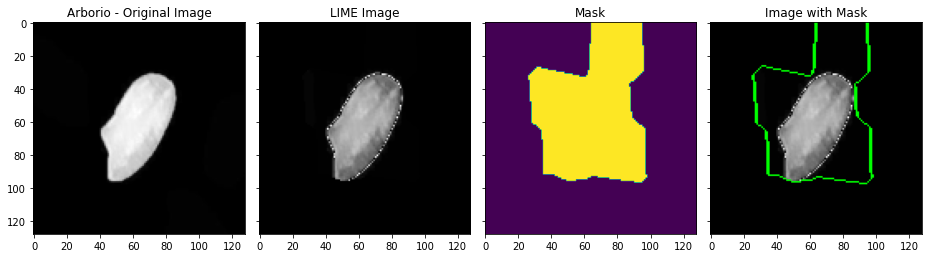

  0%|          | 0/1000 [00:00<?, ?it/s]

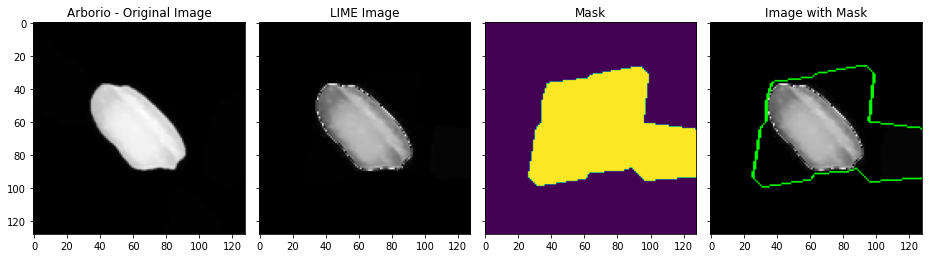

  0%|          | 0/1000 [00:00<?, ?it/s]

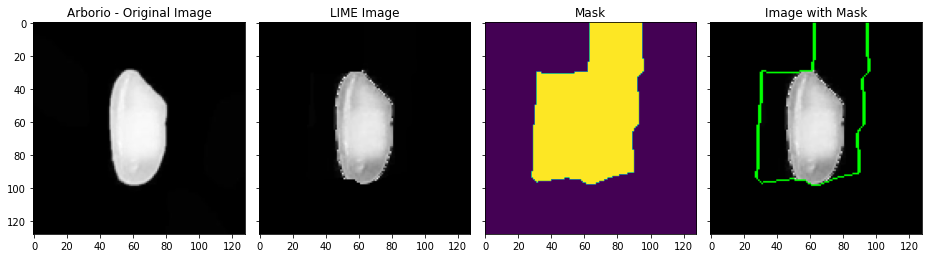

  0%|          | 0/1000 [00:00<?, ?it/s]

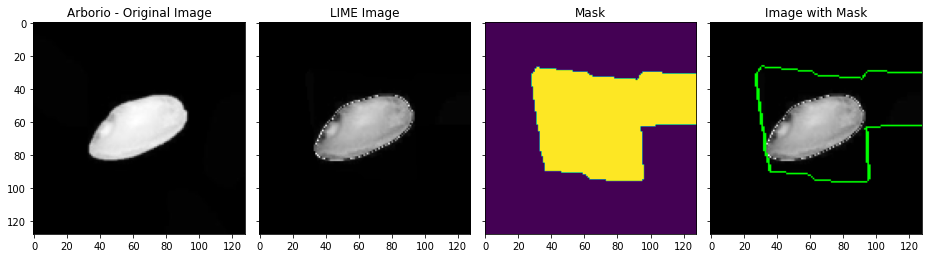

  0%|          | 0/1000 [00:00<?, ?it/s]

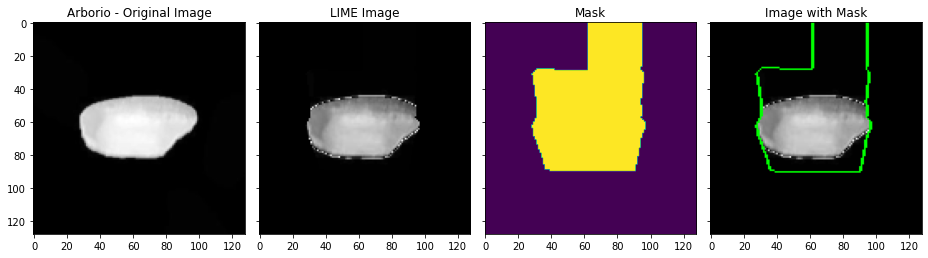

  0%|          | 0/1000 [00:00<?, ?it/s]

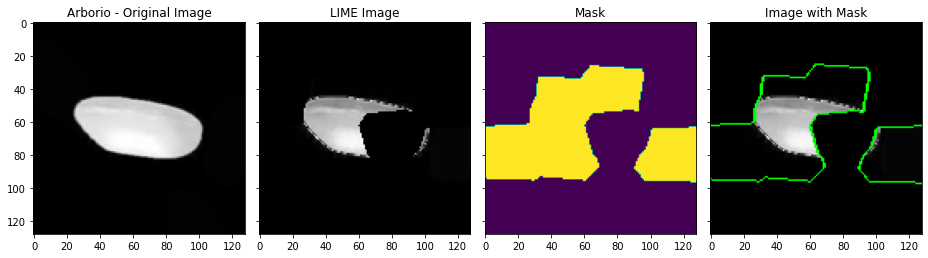

  0%|          | 0/1000 [00:00<?, ?it/s]

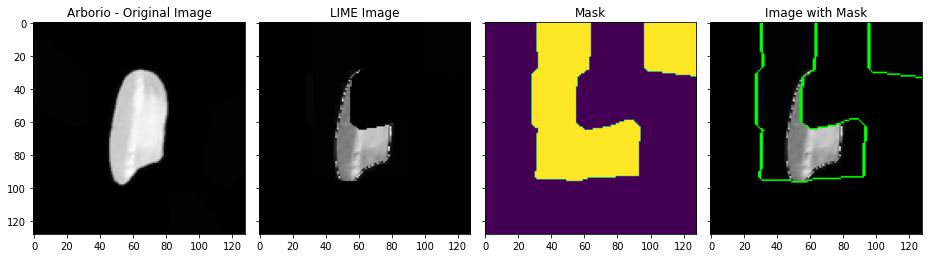

  0%|          | 0/1000 [00:00<?, ?it/s]

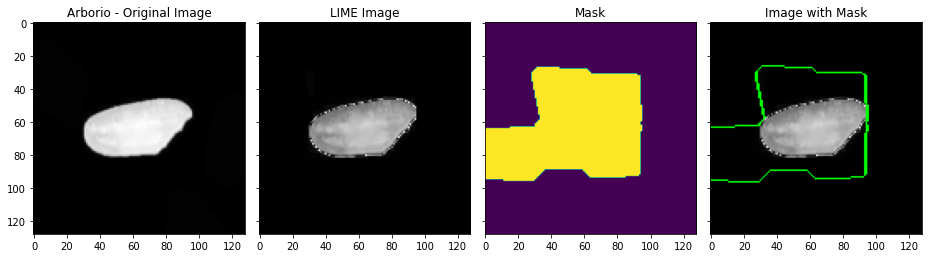

  0%|          | 0/1000 [00:00<?, ?it/s]

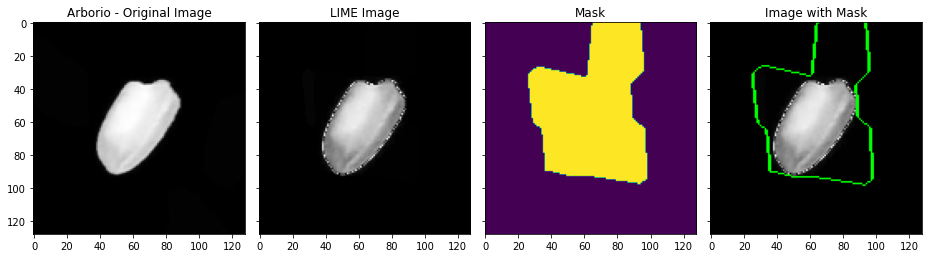

  0%|          | 0/1000 [00:00<?, ?it/s]

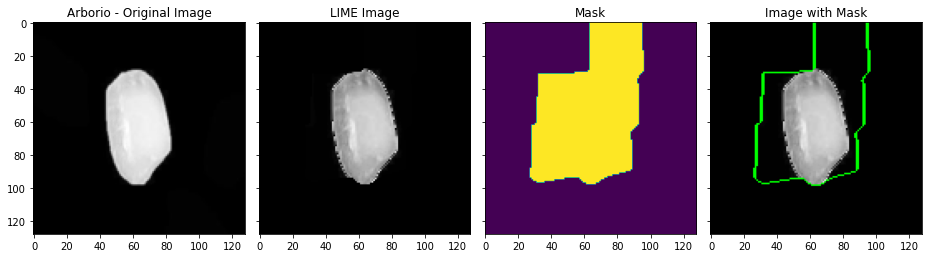

  0%|          | 0/1000 [00:00<?, ?it/s]

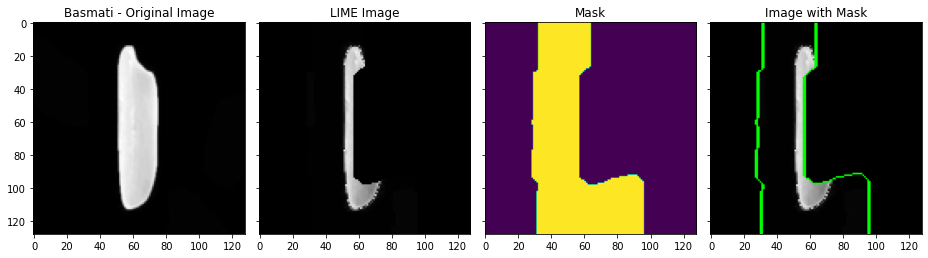

  0%|          | 0/1000 [00:00<?, ?it/s]

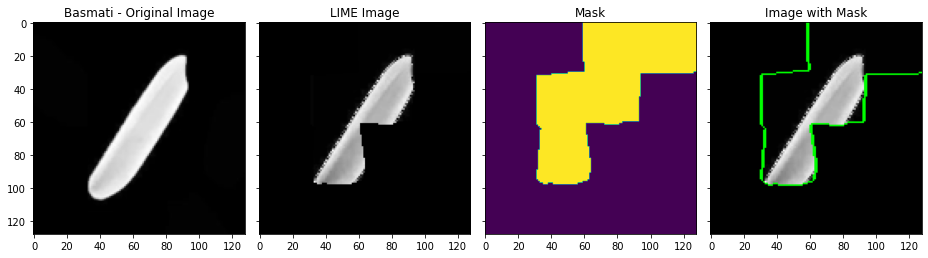

  0%|          | 0/1000 [00:00<?, ?it/s]

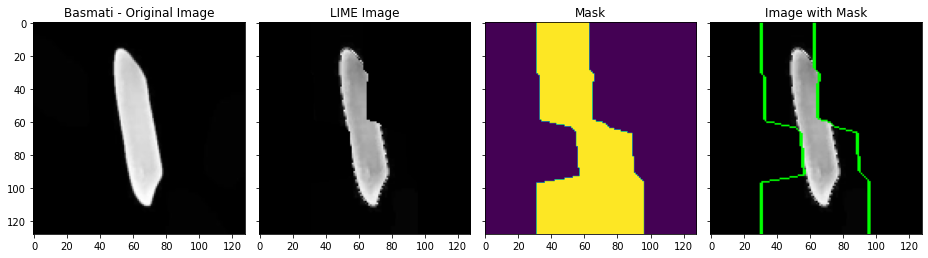

  0%|          | 0/1000 [00:00<?, ?it/s]

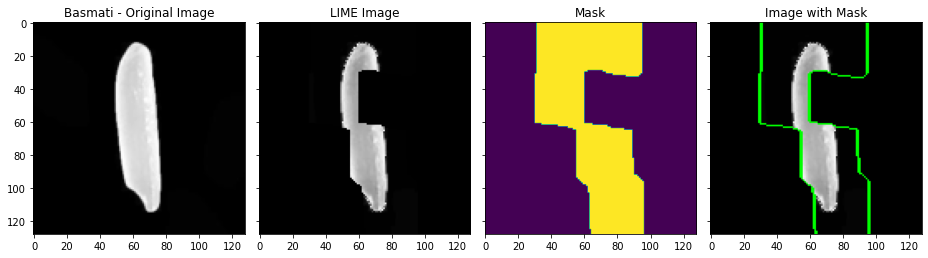

  0%|          | 0/1000 [00:00<?, ?it/s]

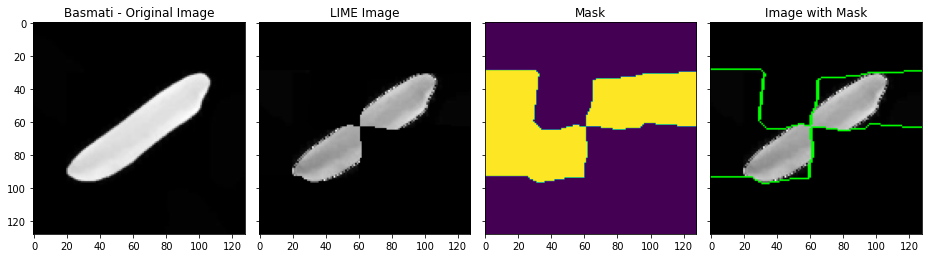

  0%|          | 0/1000 [00:00<?, ?it/s]

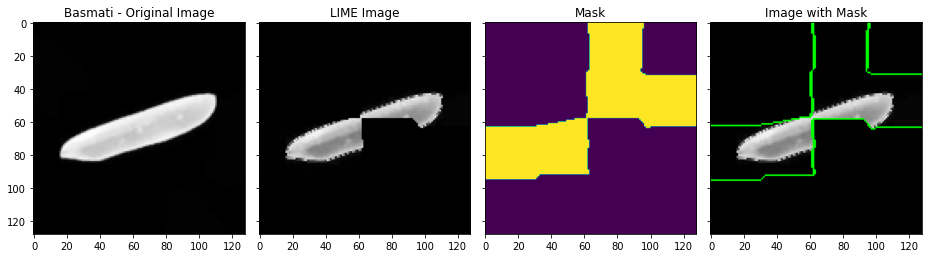

  0%|          | 0/1000 [00:00<?, ?it/s]

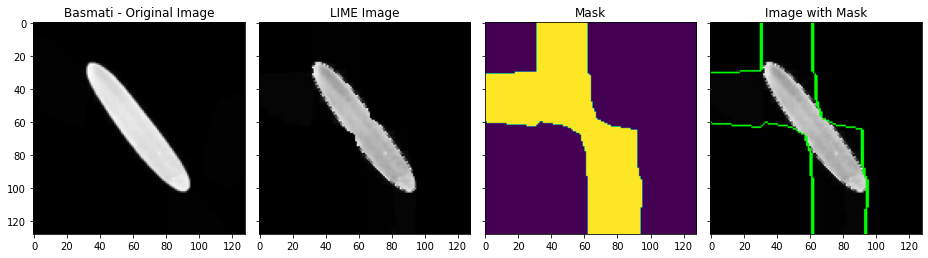

  0%|          | 0/1000 [00:00<?, ?it/s]

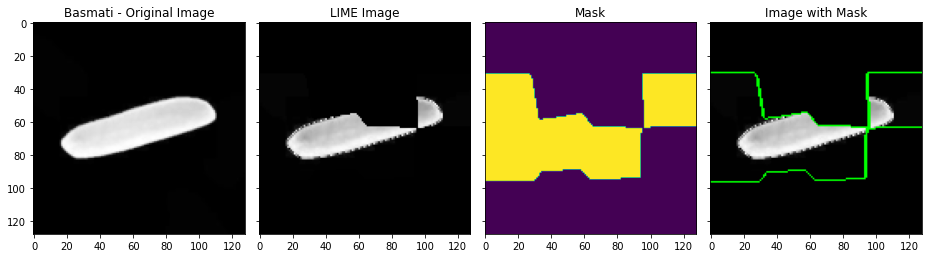

  0%|          | 0/1000 [00:00<?, ?it/s]

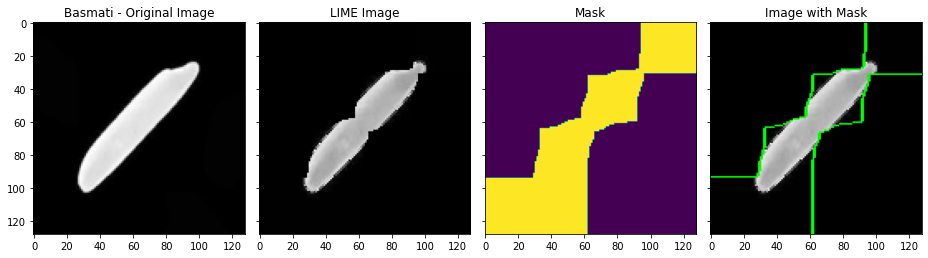

  0%|          | 0/1000 [00:00<?, ?it/s]

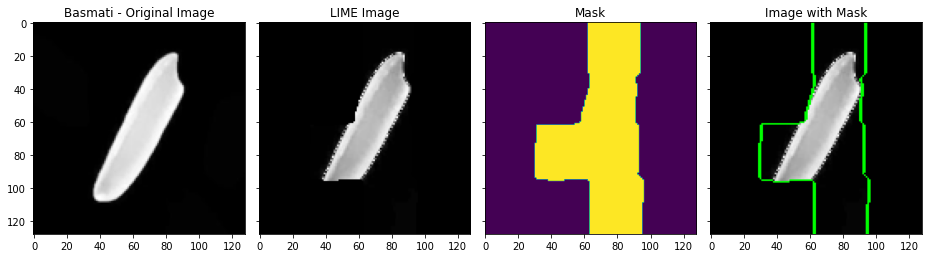

  0%|          | 0/1000 [00:00<?, ?it/s]

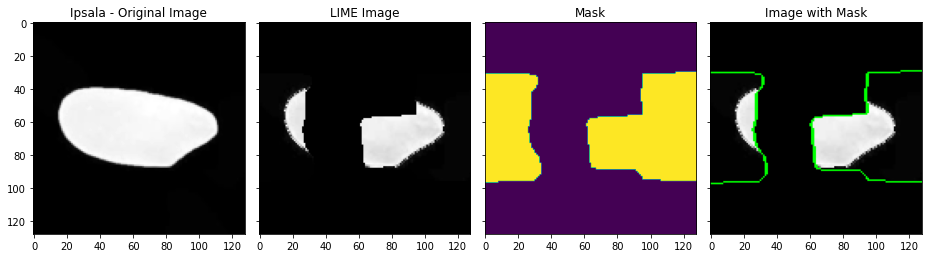

  0%|          | 0/1000 [00:00<?, ?it/s]

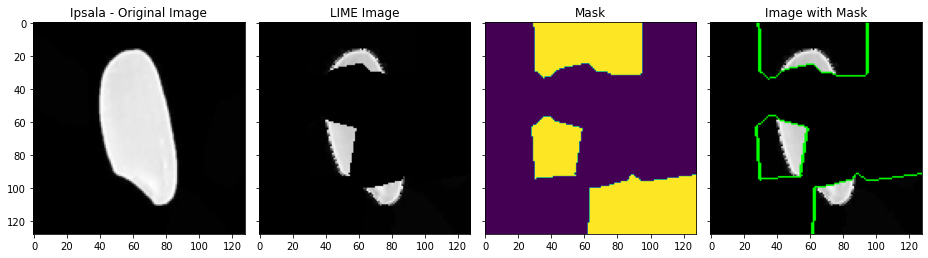

  0%|          | 0/1000 [00:00<?, ?it/s]

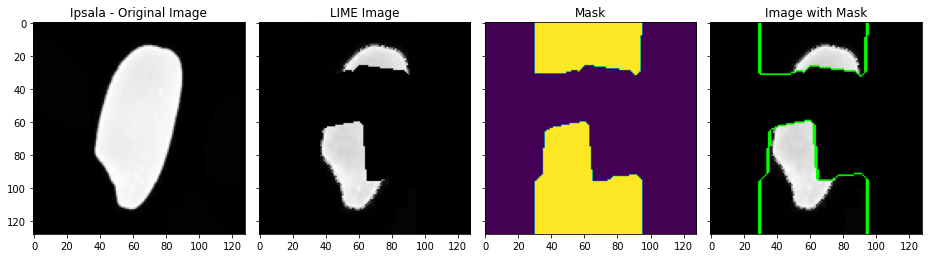

  0%|          | 0/1000 [00:00<?, ?it/s]

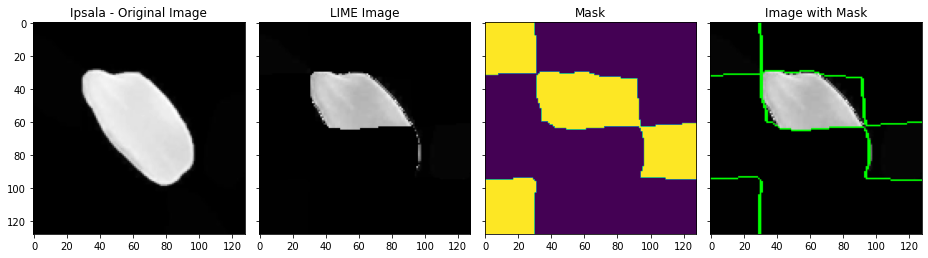

  0%|          | 0/1000 [00:00<?, ?it/s]

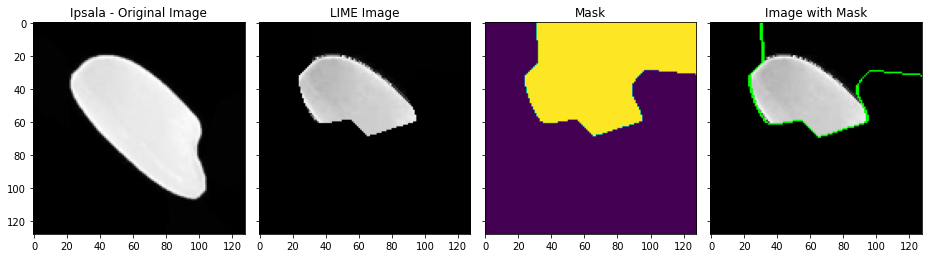

  0%|          | 0/1000 [00:00<?, ?it/s]

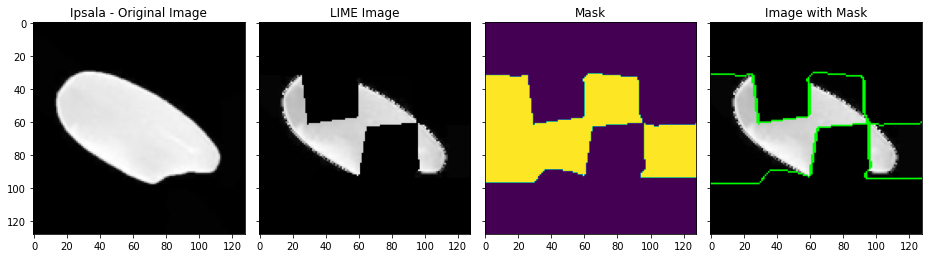

  0%|          | 0/1000 [00:00<?, ?it/s]

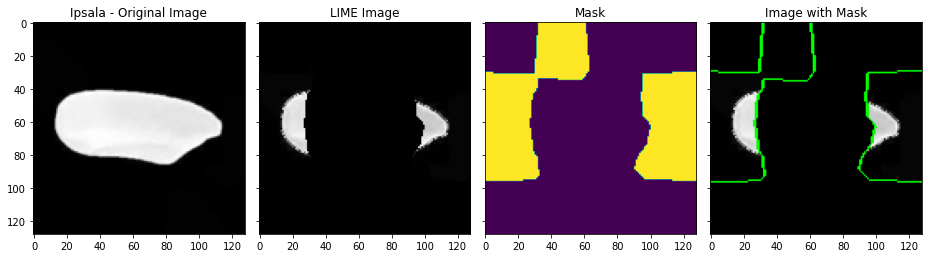

  0%|          | 0/1000 [00:00<?, ?it/s]

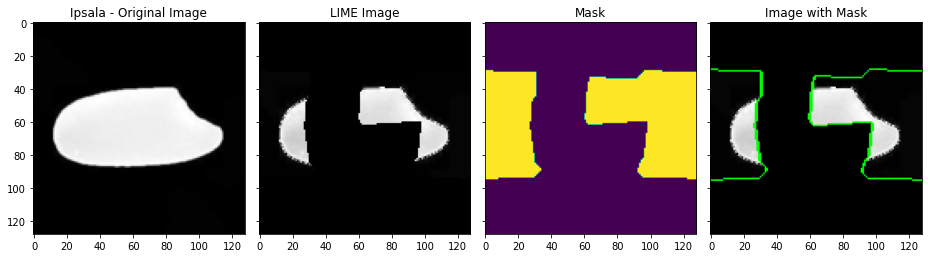

  0%|          | 0/1000 [00:00<?, ?it/s]

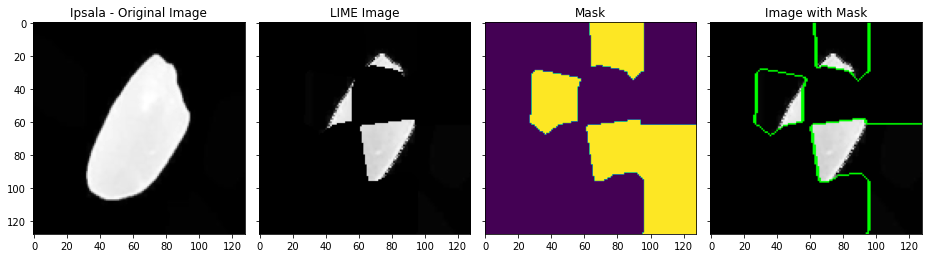

  0%|          | 0/1000 [00:00<?, ?it/s]

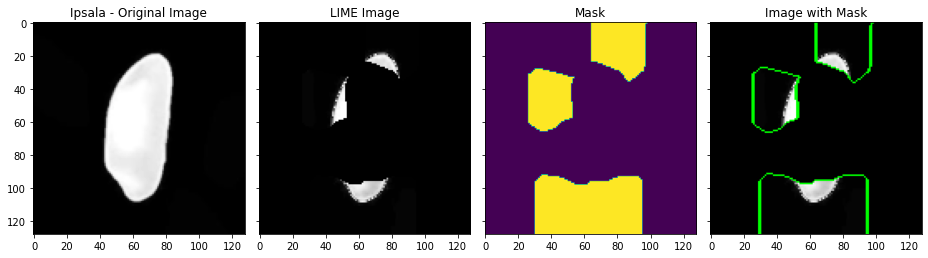

  0%|          | 0/1000 [00:00<?, ?it/s]

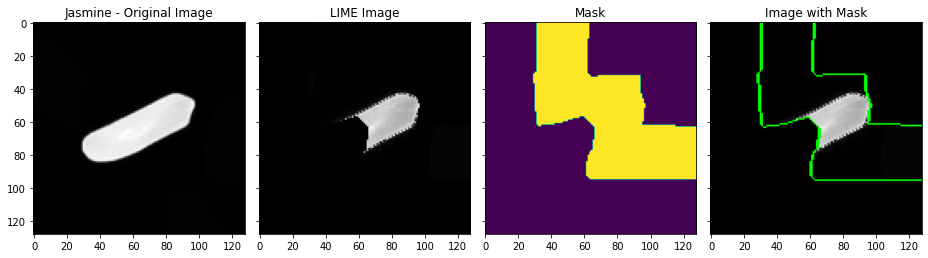

  0%|          | 0/1000 [00:00<?, ?it/s]

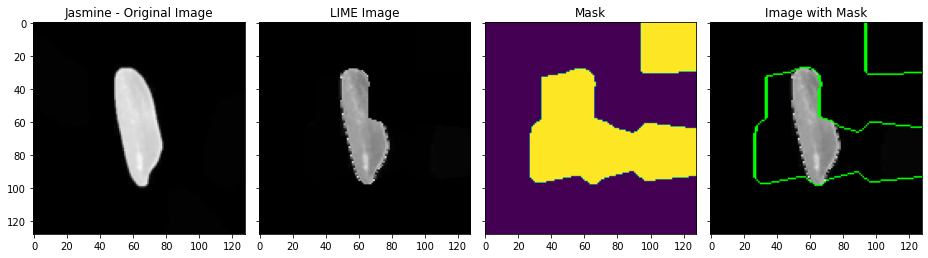

  0%|          | 0/1000 [00:00<?, ?it/s]

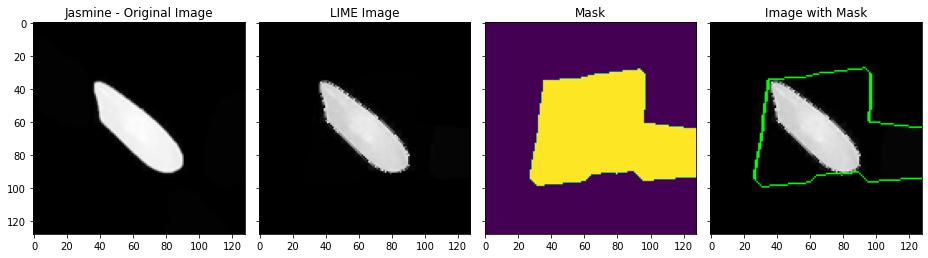

  0%|          | 0/1000 [00:00<?, ?it/s]

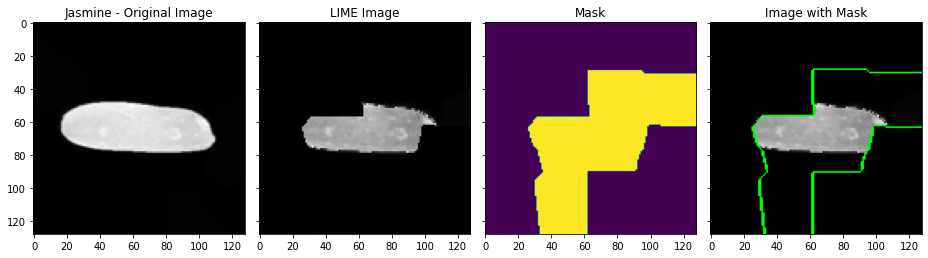

  0%|          | 0/1000 [00:00<?, ?it/s]

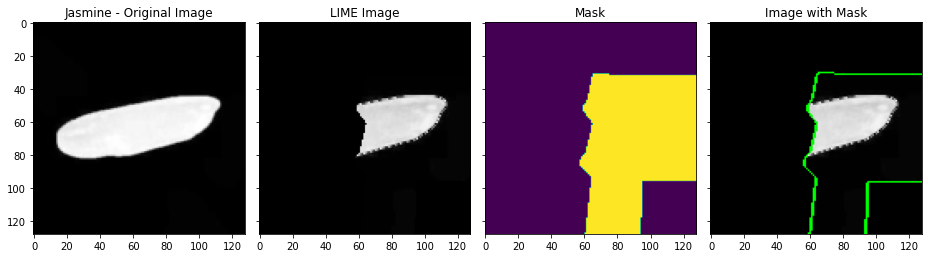

  0%|          | 0/1000 [00:00<?, ?it/s]

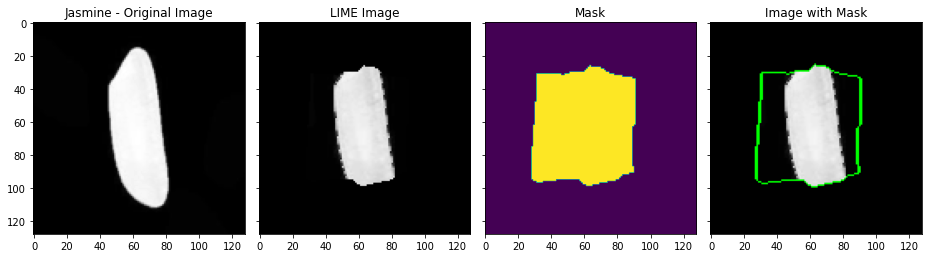

  0%|          | 0/1000 [00:00<?, ?it/s]

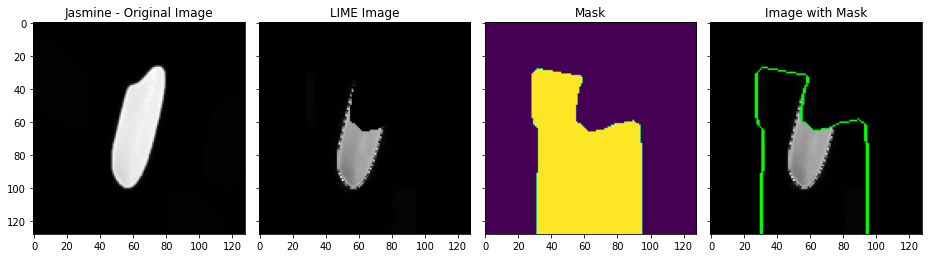

  0%|          | 0/1000 [00:00<?, ?it/s]

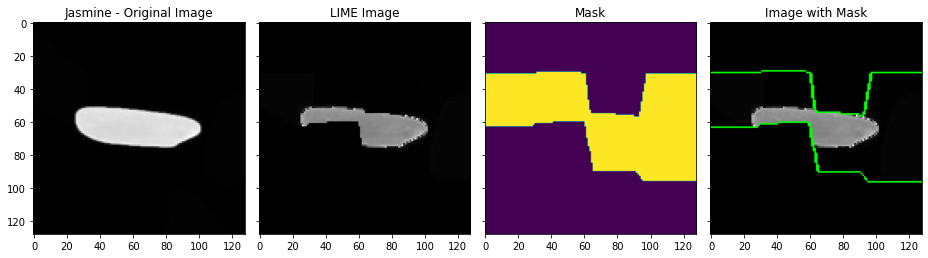

  0%|          | 0/1000 [00:00<?, ?it/s]

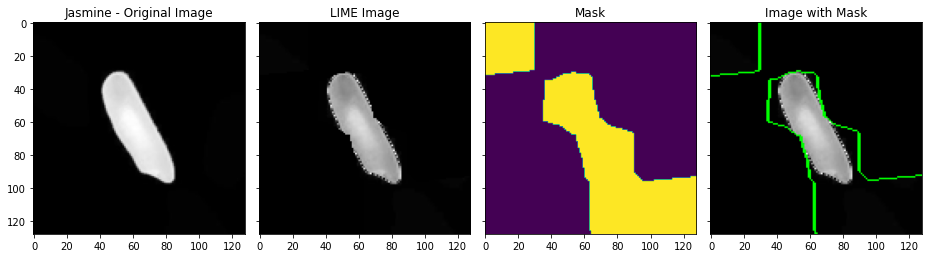

  0%|          | 0/1000 [00:00<?, ?it/s]

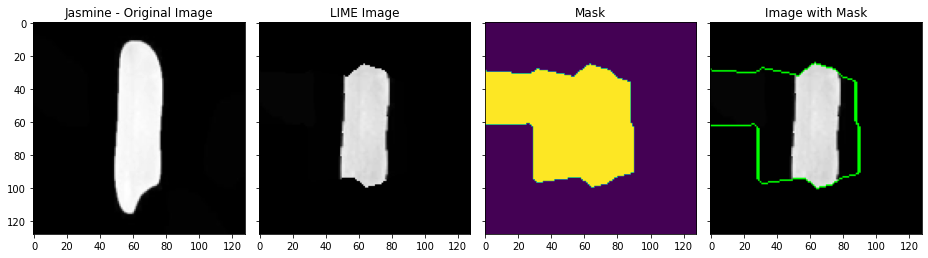

  0%|          | 0/1000 [00:00<?, ?it/s]

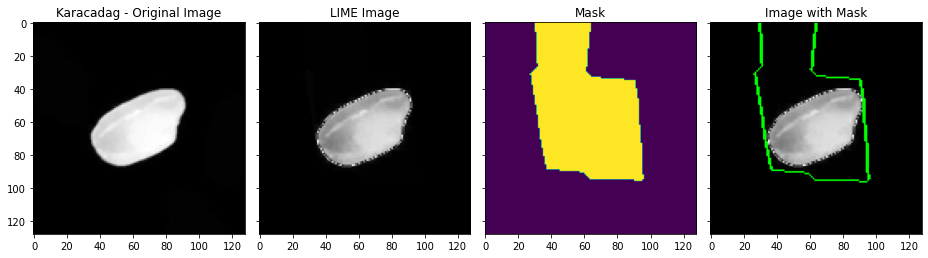

  0%|          | 0/1000 [00:00<?, ?it/s]

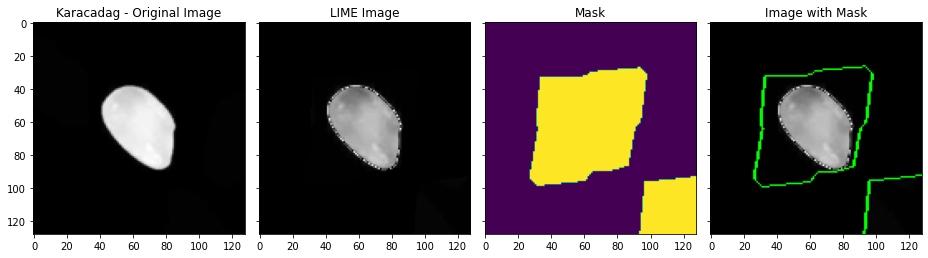

  0%|          | 0/1000 [00:00<?, ?it/s]

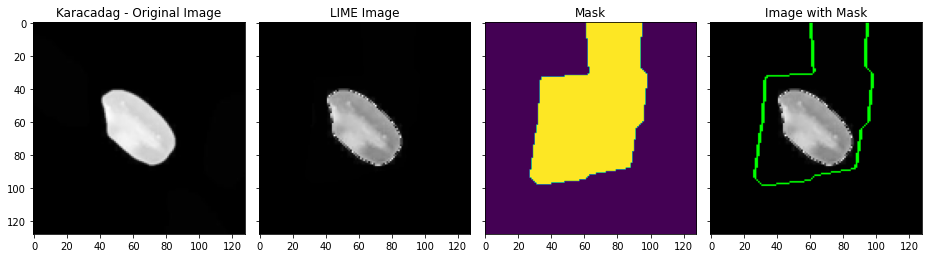

  0%|          | 0/1000 [00:00<?, ?it/s]

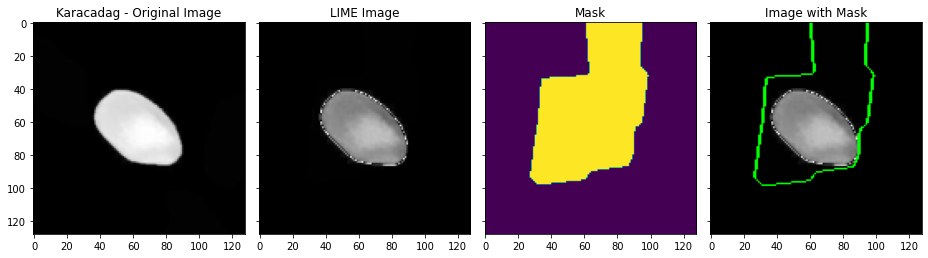

  0%|          | 0/1000 [00:00<?, ?it/s]

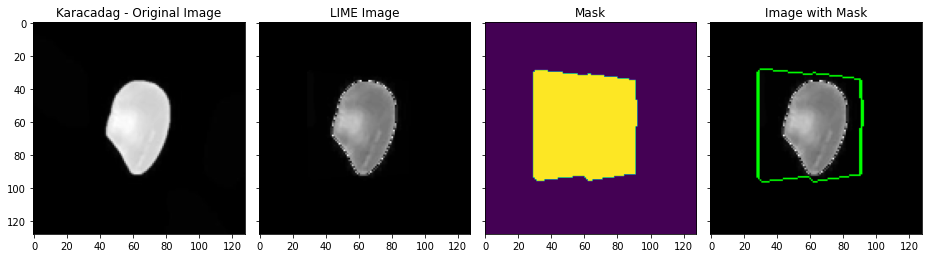

  0%|          | 0/1000 [00:00<?, ?it/s]

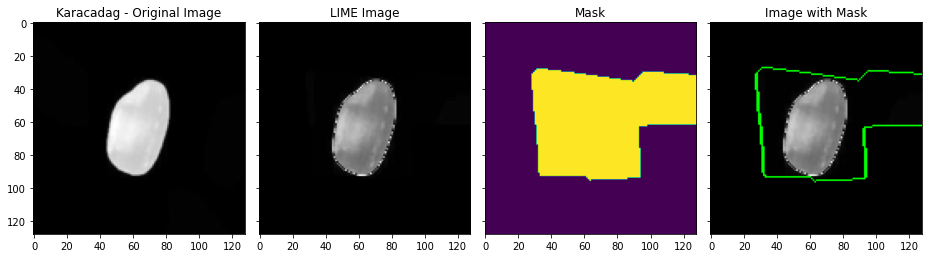

  0%|          | 0/1000 [00:00<?, ?it/s]

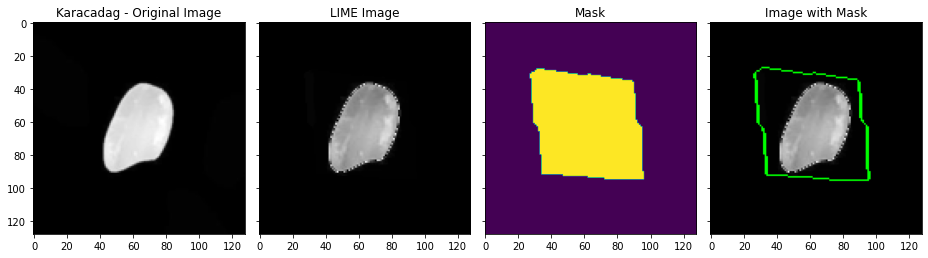

  0%|          | 0/1000 [00:00<?, ?it/s]

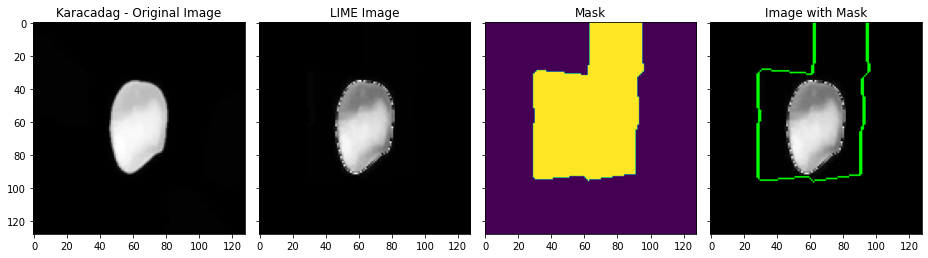

  0%|          | 0/1000 [00:00<?, ?it/s]

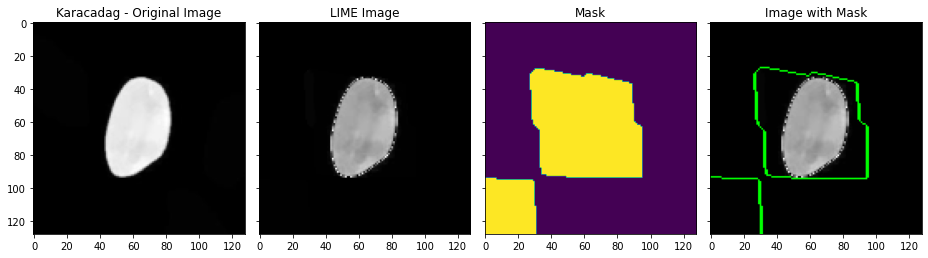

  0%|          | 0/1000 [00:00<?, ?it/s]

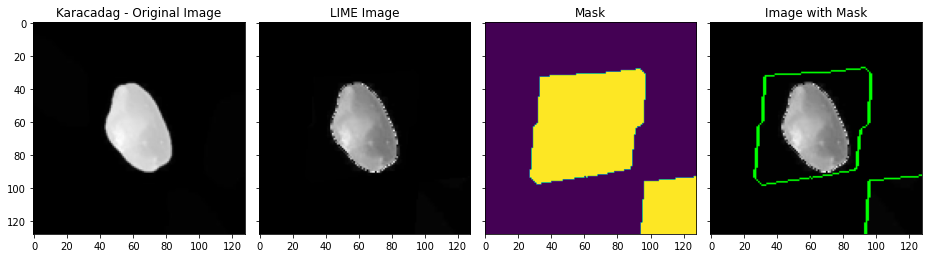

In [27]:
exp_ix(test_loader, class_labels, num_images=10)

Within the custom slic segmentation function, I ended up choosing the parameters with 20 n_segments, 220 compactness, and sigma of 1. These values gave the best lime images for the five rice classes. The left plot is the image of the original rice image. The second plot is the lime image that highlights the most important regions of the image that contributed to the prediction. Not all lime images show the entire rice image, which happened most often to the Basmati, Ipsala, and Jasmine rice. The third plot is the mask that shows the important areas that contributed to the prediction in yellow. This shows which superpixels (regions of the image) the model focused on to make the decision. The fourth plot is the lime image layered with the mask outlined in green to show the most important pixels used for predictions.

Let's find out the most distinctive pixels/features for each rice class. Each mask highlights the regions of the input images that contribute the most to the model's prediction for that class by using the LIME. I'm going to calculate the mean scores for each pixel across all mask for each class. This indicates how consistently important that pixel is for predicting the class across the set of images. Pixels with the highest mean scores can give insight into which regions of the images are most relevant for the model's classification decision for that class. This will give the overall importance of each pixel across multiple images within the same class. Then, I will iterate over the masks for each class to find the locations (indices) of the pixel with the highest score using np.argwhere. I will plot the most important pixels over each averaged mask image. 

First, I will create a function to group the predicted images together and store the indices to keep track of where it's located:

In [30]:
def group_predicted_images(test_loader, pred_method=cnn.predict):
    grouped_pred_indices = defaultdict(list)
    pred_labels = pred_method(test_loader)
    for idx, label in enumerate(pred_labels):
        grouped_pred_indices[label].append(idx)
    return grouped_pred_indices

Create a function to get the masks of 10 predicted images:

In [32]:
def get_masks(test_loader, pred_method=cnn.predict, num_images=10):
    grouped_images = group_predicted_images(test_loader, pred_method)
    lime_mask_groups = defaultdict(list)
    total_img_processed = 0
    explainer = lime_image.LimeImageExplainer()
    
    for key, indices in grouped_images.items():
        for _ix in indices:
            images, _ = next(iter(test_loader))  # Get a batch of images
            if _ix >= images.shape[0]:
                continue  # Skip if index exceeds the batch size
            img = images[_ix].cpu().numpy().squeeze()
            cnn.model.to(Device)
            images = images.to(Device)
            exp = explainer.explain_instance(image=img, classifier_fn=predict_lime, segmentation_fn=custom_segmentation)
            img, mask = exp.get_image_and_mask(exp.top_labels[0], positive_only=True, hide_rest=True)
            lime_mask_groups[key].append(mask)
            total_img_processed += 1
            if total_img_processed >= num_images:
                break  
    return lime_mask_groups

Let's group the masks for each class:

In [34]:
%%time

grouped_images_masks = get_masks(test_loader)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: total: 18min 41s
Wall time: 3min 4s


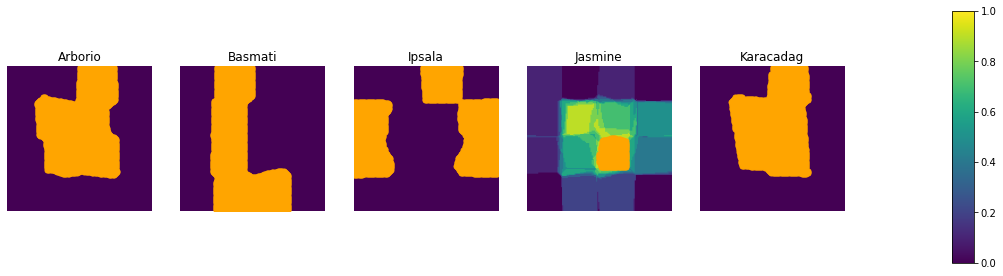

In [35]:
mean_scores = {}
for label, masks in grouped_images_masks.items():
    mean_mask = np.mean(masks, axis=0)
    mean_scores[label] = mean_mask

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
for enum, ax in enumerate(axes.ravel()):
    im = ax.imshow(mean_scores[enum])
    ax.set_title(labels_map[enum])
    ax.axis('off')

    # Find the location of the most important pixels
    max_indices = np.argwhere(mean_scores[enum] == np.max(mean_scores[enum]))

    # Plot the most important pixel
    for idx in max_indices:
        ax.plot(idx[1], idx[0], 'o', markersize=5, color='orange')

cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)

plt.show()

These plots show the averaged mean scores of the masks for each image class. The orange areas show the most important pixels for classification of each image. In the first 10 images, there were enough whole lime images of Jasmine, so we got a decent density plotted in the background as teal and green areas. As we've observed previously, all rice images are centered, but at different rotations between images; therefore, it makes sense that the orange area is in the center for the Jasmine rice. Arborio, Bamasti, and Karacadag have orange areas in the general center area as expected. Ipsala's size of the grain is much bigger than the rest of the rice types, so it makes sense that more of the outer edges of plot is highlighted with orange. Overall, for centered images these distinctive pixels are decent representation for the image classification. I'm curious if using more data and masks would help us define a better distinction of important pixels. Let's see what the most important pixels are for using 50 of the test images:

In [40]:
%%time

grouped_images_masks = get_masks(test_loader, num_images=50)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: total: 31min 18s
Wall time: 11min 47s


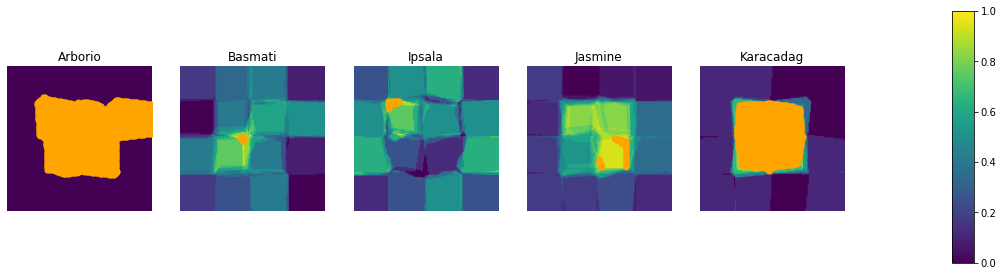

In [41]:
mean_scores = {}
for label, masks in grouped_images_masks.items():
    mean_mask = np.mean(masks, axis=0)
    mean_scores[label] = mean_mask

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
for enum, ax in enumerate(axes.ravel()):
    im = ax.imshow(mean_scores[enum])
    ax.set_title(labels_map[enum])
    ax.axis('off')

    # Find the location of the most important pixels
    max_indices = np.argwhere(mean_scores[enum] == np.max(mean_scores[enum]))

    # Plot the most important pixel
    for idx in max_indices:
        ax.plot(idx[1], idx[0], 'o', markersize=5, color='orange')

cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)

plt.show()

Using more data and masks increased the density of Jasmine. With 50 image data and masks I get a narrowed representation of the important pixels (orange areas) for Basmati, Ipsala, Jasmine, and Karacadag. Arborio stayed the same while Arborio's orange area did get smaller, but not significant enough. For Ipsala the orange area is now highlighted in the central region of the image. I'm curious if I can get a better density for the classes with even more data and masks. Let's see how the orange important pixels change with 100 images:

In [43]:
%%time

grouped_images_masks = get_masks(test_loader, num_images=100)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: total: 38min 9s
Wall time: 17min 21s


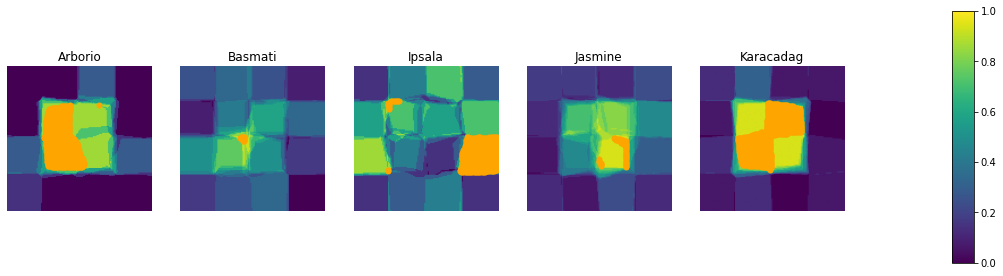

In [44]:
mean_scores = {}
for label, masks in grouped_images_masks.items():
    mean_mask = np.mean(masks, axis=0)
    mean_scores[label] = mean_mask

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
for enum, ax in enumerate(axes.ravel()):
    im = ax.imshow(mean_scores[enum])
    ax.set_title(labels_map[enum])
    ax.axis('off')

    # Find the location of the most important pixels
    max_indices = np.argwhere(mean_scores[enum] == np.max(mean_scores[enum]))

    # Plot the most important pixel
    for idx in max_indices:
        ax.plot(idx[1], idx[0], 'o', markersize=5, color='orange')

cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)

plt.show()

With 100 image data and masks we get better rice image densities for all rice types. The orange areas that highlight the important pixels for classification is narrowed down to specific areas of the rice images for Arborio and Karacadag. Basmati's and Jasmine's important pixels stayed the same. Ipsala now has more important pixels highlighted for classification. More image data and masks allow us to see the important pixels in relation to the image density.

## Conclusion

In this rice classification project, a Convolutional Neural Network (CNN) was developed using PyTorch to classify five different rice varieties: Arborio, Basmati, Ipsala, Jasmine, and Karacadag. The model was trained on a dataset consisting of 75,000 grayscale images, with 15,000 images for each rice type. Throughout the training process, the model demonstrated strong performance, with consistent improvements in both training and validation accuracies. By the final epoch, the model achieved a high validation accuracy of 98.44%, indicating excellent generalization across the dataset.

A key component of this project was the integration of LIME (Local Interpretable Model-Agnostic Explanations) for explainability. LIME was used to provide insights into the model's decision-making process by generating interpretable visual explanations for the model's predictions. Specifically, LIME helped highlight the regions of rice grain images that the model considered most important for classification. This technique proved particularly useful in analyzing challenging classes, such as Basmati and Jasmine, where the model needed to differentiate subtle visual features.

The use of LIME allowed for the identification of potential areas of improvement, as it revealed which image segments contributed most to incorrect predictions. By understanding the model's decision boundaries through these visual explanations, I were able to assess the robustness of the model and gain confidence in its ability to make accurate predictions.